<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

# Assignment 2 EEG Data Analysis

*This assignment is an exploration into a dataset of EEG data on patients. The best description given by the authors of the original data is "Resting state EEG with closed eyes and open eyes in females from 60 to 80 years old", found here:
'https://openneuro.org/datasets/ds005420/versions/1.0.0'. The data contains EEG measurements using 20 electrodes, which measure brain activity, where the subjects where asked to keep their eyes open (oa) and then closed (oc) for around 4-5 minutes. For the purposes of this exercise we have taken a subset of 8 subjects using only 200 seconds of each of oc and oc to align the sizes.*

*The main aim is to give you an application of the Discrete Fourier Transform on real world data. As this step can be done in a single function a lot of the time spent on this exercise will be on visually inspecting the data and trying different classifiers on the data you have produced. If you are lucky enough to draw this assignment for your exam you should be prepared to answer mainly theoretical questions about the Fourier Transform as covered in the exercises and lectures from week 5&6.*


</span>

In [6]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.signal as signal

from os.path import join

import pandas as pd
from tqdm.notebook import tqdm

At first, we import the eeg data

In [7]:
path_data = "egg_data_assignment_2"
data_oa_original = []
data_oc_original = []
sample_rate = 50
sample_rate_original = 250

for folder in tqdm(os.listdir(path_data), desc="Loading data"):
    for filename in os.listdir(join(path_data, folder)):
        df = pd.read_csv(join(path_data, folder, filename), sep=",", index_col=0)
        if "oa" in filename:
            data_oa_original.append(df.values)
        else:
            data_oc_original.append(df.values)
            

Loading data:   0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
print(F"Loaded data from {len(data_oa_original)} patients")

Loaded data from 8 patients


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 1
**1. Let's take a look at the data by investigating the shape of it. What is the maximum frequency we can represent given the length?**

*Hint: Remember to factor in the sample rate*

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

2/F_s  dermed 250/2 = 125

</span>

</span>

In [9]:
for idx, (d_oc, d_oa) in enumerate(zip(data_oc_original, data_oa_original)):
    print(f"Shape of OC: {d_oc.shape}, Shape of OA: {d_oa.shape}")

Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

*Now we want to center all the data around the same value (0), in eeg data analysis terms this is called referencing, and down sample in order to have a manageable size that a normal pc with 16 Gb of RAM can manipulate. Here we will apply a simple average referencing*

**2. Implement the following function:**

</span>


In [15]:
def set_reference_and_downsample(eeg_data, ref_channels, sample_rate=50):
    """Take the mean of the reference channels and subtract that from the data"""
    eeg_masked = eeg_data[ref_channels]
    eeg_down_sampled = signal.resample(eeg_masked, eeg_masked.shape[1] // (sample_rate_original // sample_rate), axis=1)
    
    ref_signal = np.mean(eeg_down_sampled, axis=0)
    
    # Subtraher reference-signalet fra alle kanaler
    re_referenced_data = eeg_down_sampled - ref_signal
    return re_referenced_data

*We will reference and down sample each patient's data individually:*

In [16]:
data_oc = []
data_oa = []
for i in range(len(data_oa_original)):
    data_oc.append(set_reference_and_downsample(data_oc_original[i], np.arange(20), sample_rate=sample_rate))
    data_oa.append(set_reference_and_downsample(data_oa_original[i], np.arange(20), sample_rate=sample_rate))

In [17]:
for idx, (d_oc, d_oa) in enumerate(zip(data_oc, data_oa)):
    print(f"Shape of OC: {d_oc.shape}, Shape of OA: {d_oa.shape}")

Shape of OC: (20, 10000), Shape of OA: (20, 10000)
Shape of OC: (20, 10000), Shape of OA: (20, 10000)
Shape of OC: (20, 10000), Shape of OA: (20, 10000)
Shape of OC: (20, 10000), Shape of OA: (20, 10000)
Shape of OC: (20, 10000), Shape of OA: (20, 10000)
Shape of OC: (20, 10000), Shape of OA: (20, 10000)
Shape of OC: (20, 10000), Shape of OA: (20, 10000)
Shape of OC: (20, 10000), Shape of OA: (20, 10000)


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**3. Using the following plotting function, have a look at the data and comment on the quality of it:**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

A lot of noice.

</span>

</span>


In [18]:
def plot_eeg_mne_style(eeg_data, ch_names, sampling_rate):
    """
    Plot EEG data in an MNE-style plot for each channel.

    Parameters:
    eeg_data : np.ndarray
        The EEG data with shape (n_channels, n_points).
    ch_names : list of str
        List of channel names (must be of length n_channels).
    sampling_rate : float
        The sampling rate of the EEG data (in Hz).
    """    
    # Create MNE info structure with channel names and sampling rate
    info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types='eeg')
    
    # Create MNE RawArray object with the data
    raw = mne.io.RawArray(eeg_data, info)
    
    # Plot the EEG data with MNE's built-in plot function
    raw.plot(scalings='auto', show=True, block=True)
    plt.show()

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...   199.980 secs
Ready.
Using matplotlib as 2D backend.


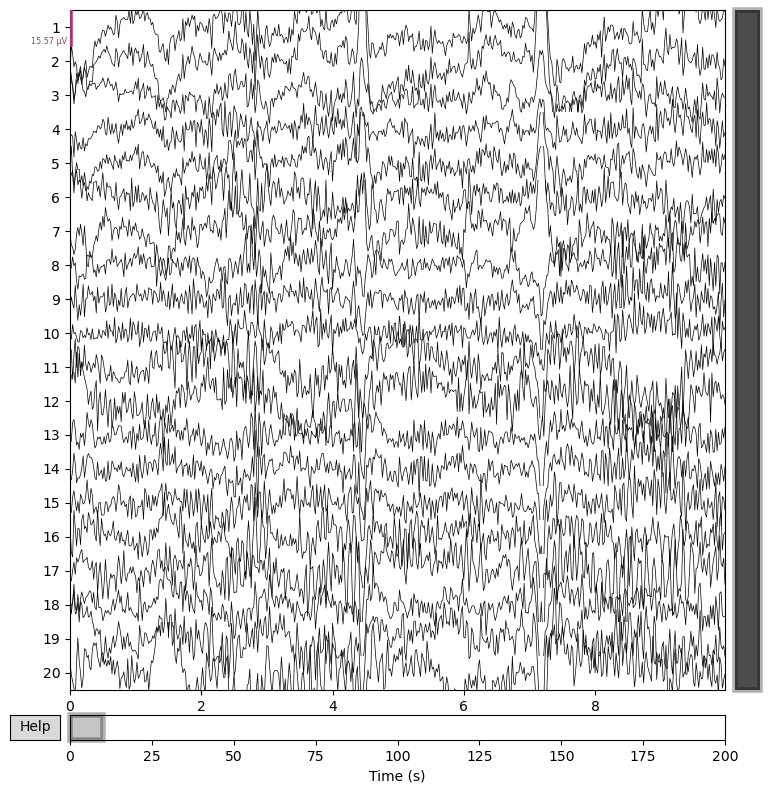

In [19]:
channel_names = np.arange(1,21,1).astype(str).tolist()
plot_eeg_mne_style(data_oa[4], ch_names=channel_names, sampling_rate=sample_rate)

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 2 Discrete Fourier Transform
Given the sample rate and duration of the EEG signals we have just loaded, complete this exercise using the signal from the first channel of the first OC patient. 

**1. Using the formula for fourier coefficients: $c_k = \sum_{n = 0}^{N-1} x(n) e^{-i 2\pi \frac{kn}{N}}$, calculate the fourier coefficient for the signal corresponding to $k = 25$**

</span>

In [25]:
N = data_oc[0][0]
fs = sample_rate
k = 25
coeff_k = 0
for n, x_n in enumerate(data_oc[0][0]):
    coeff_k += x_n * np.exp(-2j * np.pi * k * n / N)
print(f"Fourier coefficient {k} = {coeff_k:.3}")
print(f"Absolute value = {np.abs(coeff_k):.3}")

KeyboardInterrupt: 

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**2. Calculate the frequency that the fourier coefficient for $k = 25$ corresponds to**

</span>

In [ ]:
F_K = ...

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**3. Calculate the amplitude of the frequency that corresponds to the fourier coefficient for $k = 1$**


</span>

In [ ]:
A_K = ...

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 3 Frequency Domain and Filtering

*In this exercise you will take a time domain filter, plot its frequency response and use it to filter the data. Let's create the orthogonal basis matrix, but here in a vectorised function because otherwise it'd take too long.*

</span>

In [ ]:
def create_basis(N, fs):
    # Ensure N is odd
    assert N % 2 == 1

    ns = np.arange(N)
    n_pairs = int((N - 1) / 2)

    freqs = np.arange(int(0.5 * N) + 1) * fs / N

    # Create cosine and sine terms for all frequencies at once
    ks = np.arange(1, n_pairs + 1)
    angles = 2 * np.pi * np.outer(ns, ks) / N

    cosines = np.sqrt(2) * np.cos(angles)
    sines = np.sqrt(2) * np.sin(angles)

    # Create basis matrix with first column of ones, then interleave cosines and sines
    V = np.ones((N, N))
    V[:, 1::2] = cosines  # Fill odd-indexed columns with cosines
    V[:, 2::2] = sines    # Fill even-indexed columns with sines

    # Normalize by sqrt(N)
    V /= np.sqrt(N)

    return freqs, V

def compute_spectrum(y, V, scale=True):
    z = V.T@y

    z_cos = z[2::2] 
    z_sin = z[1::2]
    amp_spectrum = np.sqrt(z_cos**2 + z_sin**2)
    amp_spectrum = np.hstack((np.abs(z[0]), amp_spectrum))
    
    if scale:
        scales = np.ones(len(amp_spectrum))
        scales[0] = 1
        scales[1:] = np.sqrt(2)


        return amp_spectrum/np.sqrt(len(y))*scales
    else:
        return amp_spectrum

In [ ]:
N_odd = N-1
# prepare basis matrix V
freqs, V = create_basis(N-1, sample_rate)

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**1. Below you are given a time domain filter, plot it and comment on its shape. How do you think it does its filtering?**

*Hint: If this doens't seem straight forward, it's likely because it isn't*

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

</span>

In [ ]:
h = np.array([0.00206512, -0.00246738, -0.00061028, -0.00412665, -0.00860358, 0.00576032,
                 -0.00815993, 0.02454267, 0.0238489, 0.00708215, 0.05402169, -0.07304967,
                 -0.01784375, -0.11967235, -0.28945082, 0.40677716, 0.40677716, -0.28945082,
                 -0.11967235, -0.01784375, -0.07304967, 0.05402169, 0.00708215, 0.0238489,
                 0.02454267, -0.00815993, 0.00576032, -0.00860358, -0.00412665, -0.00061028,
                 -0.00246738, 0.00206512])

In [ ]:
plt.plot(h)
plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**2.Using the function that computes the spectrum of a signal to look at the frequency response of the filter? How do you make the dimensions match between the filter and the orthogonal basis matrix?**
*Hint: use padding*

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

</span>

In [ ]:
htilde = ?
htilde[?] = ?

plt.figure(figsize=(10, 5))
plt.plot(freqs, compute_spectrum(?))
plt.xlabel('Frequency ')
plt.title('Frequency response of filter h')
plt.show()

*$\star$ In the following cell we create the time domain filter, this is outside the scope of the course, but a very interesting topic to look into if you have the time. In addition there is a simpler function for calculating the frequency response:)*

In [ ]:
def create_bandpass_kernel(lowcut, highcut, fs, numtaps=32):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design a bandpass FIR filter
    kernel = signal.firwin(numtaps, [low, high], pass_zero=False)
    
    return kernel

def frequency_response(filter_kernel, fs, padding=1000):
    # Compute the FFT of the filter kernel (rfft for real inputs)
    freq_response = np.abs(np.fft.rfft(filter_kernel, padding)) 
    
    # Compute the corresponding frequency axis
    freqs = np.abs(np.fft.rfftfreq(padding, 1/fs))  

    return freqs, freq_response
print(create_bandpass_kernel(5, 20, fs, numtaps=32))

*And here is a function to plot the frequency response of the filter using the above function:*

In [ ]:
freqs_h, freq_response_h = frequency_response(h, sample_rate)

plt.figure(figsize=(10, 5))
plt.plot(freqs_h, freq_response_h)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Magnitude (dB)', fontsize=12)
plt.title('Frequency Response of Filter', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**3. Implement a function that filters a patients eeg signal in the time domain. Warning: It might blow your mind:**
- Compare the data before and after filtering
- Try different thresholds like (1 to 3) and (40 to 70) and comment on the effects

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

</span>

In [ ]:
def bandpass_filter(signal_data, kernel):
    output = []
    for channel in signal_data:
        filtered_signal = np.convolve(?, mode='same')  # Convolve with the signal
        output.append(filtered_signal)
    output = np.array(output)
    return output

In [ ]:
filtered_channels = bandpass_filter(data_oc[0], h)
plot_eeg_mne_style(data_oc[0], ch_names=channel_names, sampling_rate=sample_rate)
plot_eeg_mne_style(np.array(filtered_channels), ch_names=channel_names, sampling_rate=sample_rate)

*$\star$ The function below does what we have just implemented in two separate functions, feel free to use it:)*

In [ ]:
def bandpass_filter_butter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    
    return filtered_data

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**4. Complete the following function which takes a signal and computes its power spectrum and removes frequencies outside the min and max in order to remove redundant information after filtering**
- Discuss the difference between computing the power spectrum of a signal and the frequency response of a filter

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

</span>

In [ ]:
def compute_power_spectrum(signal, sampling_rate, min_freq=None, max_freq=None):
    """
    Computes the power spectrum for each channel in the signal.

    Parameters:
    signal : np.ndarray
        Input signal with shape (n_channels, n_points)
    sampling_rate : float
        The sampling rate of the signal (in Hz).

    Returns:
    freqs : np.ndarray
        The frequencies corresponding to the power spectrum.
    power_spectrum : np.ndarray
        Power spectrum of each channel with shape (n_channels, n_points//2).
    """
    n_channels, n_points = signal.shape
    
    # Perform the FFT for each channel
    fft_vals = np.fft.rfft(signal, axis=1)
    
    # Compute the power spectrum (squared magnitude of the FFT)
    power_spectrum = np.abs(fft_vals) ** 2
    
    # Compute the corresponding frequencies
    freqs = np.fft.rfftfreq(n_points, 1 / sampling_rate)
    
    if min_freq is not None:
        power_spectrum = power_spectrum[?]
        freqs = freqs[?]

    if max_freq is not None:
        power_spectrum = power_spectrum[?]
        freqs = freqs[?]
        
    return freqs, power_spectrum

*This next function is just for plotting*

In [ ]:
def plot_power_spectrum_overlay(freqs, power_spectrum, ch_names, show=False, title=""):
    """
    Plot the power spectrum for all channels on the same plot.

    Parameters:
    eeg_data : np.ndarray
        The EEG data with shape (n_channels, n_points).
    sampling_rate : float
        The sampling rate of the EEG data (in Hz).
    ch_names : list of str
        List of channel names.
    """
    colors = cm.viridis(np.linspace(0, 1, len(ch_names)))

    for i, ch_name in enumerate(ch_names):
        plt.plot(freqs, power_spectrum[i], color=colors[i], label=ch_name)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.title('Power Spectrum for EEG Channels' if not title else title)
    plt.tight_layout()
    if show:
        plt.show()

*We have been advised by Ivana (Human Cognition lecturer and EEG researcher), that we should take a look at the frequencies between 5 and 20 Hz in order to get a distinction between OC and OA. Here we plot all the power spectra from each channel on top of one each other. Feel free to investigate other indexes.*

In [ ]:
patient_indexes = [0, 3, 5]
min_freq=1
max_freq=20
power_spectra_oc = []
power_spectra_oa = []
y_max = 3e-4

for segment in patient_indexes:
    plt.subplots(1, 2, figsize=(15, 5))
    
    data_oc_time_filtered = bandpass_filter(data_oc[segment], h)
    data_oa_time_filtered = bandpass_filter(data_oa[segment], h)
    # Compute power spectra for both conditions
    freqs_oc, power_spectrum_oc = compute_power_spectrum(data_oc_time_filtered, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq)
    freqs_oa, power_spectrum_oa = compute_power_spectrum(data_oa_time_filtered, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq)
    power_spectra_oc.append((freqs_oc, power_spectrum_oc))
    power_spectra_oa.append((freqs_oa, power_spectrum_oa))

    plt.subplot(1, 2, 1)
    plot_power_spectrum_overlay(freqs_oc, power_spectrum_oc, channel_names, title=f"Power spectrum for Eyes Closed (OC)")
    plt.ylim([0, y_max])
    plt.subplot(1, 2, 2)
    plot_power_spectrum_overlay(freqs_oa, power_spectrum_oa, channel_names, title=f"Power spectrum for Eyes Open (OA)")
    plt.ylim([0, y_max])
    plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**5. Using the loop above take a look at the spectrograms for eyes open and eyes closed.** 
- Is there a noticeable difference between the two? How could we use this difference for classification?
- Discuss whether the conditions of our fft are sufficient to avoid spectral leakage

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**6. The channels at index 17 and 18 are known to be correlated to have open vs closed eyes, plot these:**

</span>

In [ ]:
optical_channel_slice = slice(?)    # Look it up if in doubt as to how a slice works
data_oc_optical_channels = [arr[optical_channel_slice] for arr in data_oc]
data_oa_optical_channels = [arr[optical_channel_slice] for arr in data_oa]

In [ ]:
patient_indexes = [0, 3, 5]
min_freq=5
max_freq=20
for segment in patient_indexes:
    plt.subplots(1, 2, figsize=(15, 5))
    
    data_oc_time_filtered = bandpass_filter(data_oc_optical_channels[segment], h)
    data_oa_time_filtered = bandpass_filter(data_oa_optical_channels[segment], h)
    # Compute power spectra for both conditions
    freqs_oc, power_spectrum_oc = compute_power_spectrum(data_oc_time_filtered, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq)
    freqs_oa, power_spectrum_oa = compute_power_spectrum(data_oa_time_filtered, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq)

    plt.subplot(1, 2, 1)
    plot_power_spectrum_overlay(freqs_oc, power_spectrum_oc, channel_names[optical_channel_slice], title=f"Power spectrum for Eyes Closed (OC)")
    plt.ylim([0, y_max])
    plt.subplot(1, 2, 2)
    plot_power_spectrum_overlay(freqs_oa, power_spectrum_oa, channel_names[optical_channel_slice], title=f"Power spectrum for Eyes Open (OA)")
    plt.ylim([0, y_max])
    plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**7. Now get the power spectra from the range that seems to be the most suited for classifying the difference between OC and OA based on the visual inspection you did above:**

</span>

In [ ]:
min_freq = ?
max_freq = ?

power_spectra_oc = [compute_power_spectrum(arr, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq) for arr in data_oc_optical_channels]
power_spectra_oa = [compute_power_spectrum(arr, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq) for arr
                    in data_oa_optical_channels]

*Let's plot this smaller spectrum*

In [ ]:
for idx in patient_indexes:
    freqs_oc, spectrum_oc = power_spectra_oc[idx]
    freqs_oa, spectrum_oa = power_spectra_oa[idx]
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_power_spectrum_overlay(freqs_oc, spectrum_oc, ch_names=[17, 18,], title=f"Power spectrum for Eyes Closed (OC)")
    plt.ylim([0, y_max])

    plt.subplot(1, 2, 2)
    plot_power_spectrum_overlay(freqs_oa, spectrum_oa, ch_names=[17, 18,], title=f"Power spectrum for Eyes Open (OA)")
    plt.ylim([0, y_max])
    plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**8. Now let's compute the energies in this range, typically referred to as the alpha band, and plot them**


*Hint: recall that the energy of a signal is given by $E = \sum_{n=0}^N f(n)^2$*

</span>

In [ ]:
alphas_oc = []
alphas_oa = []
for (freqs_oc, spectrum_oc), (freqs_oa, spectrum_oa) in zip(power_spectra_oc, power_spectra_oa):
    alpha_oc = ?
    alpha_oa = ?
    
    alphas_oc.append(alpha_oc)
    alphas_oa.append(alpha_oa)
alphas_oc = np.array(alphas_oc)
alphas_oa = np.array(alphas_oa)

In [ ]:
def plot_alphas(alphas_oc, alphas_oa, show=False, s = 10):
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.scatter(range(len(alphas_oc)), alphas_oc, label='OC', color='blue', s=s) 
    plt.scatter(range(len(alphas_oa)), alphas_oa, label='OA', color='orange', s=s)
    # The following line makes a line which you can change to illustrate a decision boundary:
    plt.title('OA and OC energy of alpha frequencies compared')
    plt.xlabel('Subject')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.tight_layout()
    if show:
        plt.show()

In [ ]:
plot_alphas(alphas_oc, alphas_oa, show=True)

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**9. Now that you have processed the data using the dft and inspected the energies of the two different cases, discuss how well you believe this data could be used to create a classifier that classifies whether a person has their eyes open or closed:**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

</span>


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 4 Classification

If you have understood what is going on so far, you understand a very good portion of audio processing and the main takeaways from this assignment. Exercise 4 is still a part of it, and definitely worthwhile to complete, but don't get too stuck up on the details of bayes theorem etc. Also note that a Feed Forward Neural Network is just a simple NN with linear layers.

*The exercise here is to tie what you learned in weeks 1-3 together with audio signals processing.
 Firstly we will use a Naive Bayes classifier and then we will implement a CNN to do classification on the EEG data. Here you can spend as much time and effort as you wish refining the classification or coming up with other techniques, but be warned EEG data is notoriously noisy.*

*Also note that we are dealing with only a few patients which will give a very low granularity to the validation accuracies and may lead to easy overfitting! That is just life sometimes.*

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

**1. Implement a Naive Bayes classifier using the entire dataset to plot the posterior distribution.**

*A naive Bayes classifier assumes that the features used for classification are normally distributed according to their empirical mean and variance. The steps for classification are as follows:*
1. Find the mean and variance of the features of each class for the calculation of the likelihood $P(\alpha|C_x) = \mathcal{N}(\mu_{\alpha_x}, \sigma_{\alpha_x}^2)$
    - In our case the features are just the alpha energy
2. Define a prior distribution for each class given the features 
    - Here we use a uniform prior representing the proportion of each class in the dataset, why do you think this makes sense? $Prior(C) = 0.5$
3. Given a new value, calculate the posterior probability of belonging to OC (class 0) using Bayes theorem:
        $$
        P(C_0|\alpha) = \frac{P(\alpha|C_0) \cdot Prior(C_0)}{P(\alpha|C_0) \cdot Prior(C_0) + P(\alpha|C_1) \cdot Prior(C_1)}
        $$
        $$ 
        P(C_1|\alpha) = 1- P(C_0|\alpha)
        $$

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

*1.a Compute the means and variances*:

</span>

In [ ]:
m0, v0 = ?
m1, v1 = ?

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

*1.b Define the priors along with a helper function for calculating the pdf of a normal distribution:*

</span>

In [ ]:
def normal_pdf(x, m, v):
    return np.exp(-(x - m) ** 2 / (2 * v)) / np.sqrt(2 * np.pi * v)

def naive_bayes_prior_0(alpha_energy):
    return ?

def naive_bayes_prior_1(alpha_energy):
    return ?

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

*1.c We will define a function to compute the posterior distribution and one to use that for classification:*

</span>

In [ ]:
def compute_posterior(alpha_energy, m0, v0, m1, v1):
    likelihood_0 = ?
    likelihood_1 = ?
    
    prior_0 = ?
    prior_1 = ?
    
    return ?

def classify_naive_bayes(alpha_energy, m0, v0, m1, v1):
    return ? >= 0.5

*Now we plot the posterior probability of a given observation being OC according to our classifier. Make sure you understand what this plot represents, do ask if in doubt.*

In [ ]:
xs = np.linspace(1e-10, 3e-5, 100)
plt.figure(figsize=(10, 6))
plt.plot(xs, compute_posterior(xs, m0, v0, m1, v1))
plt.xlabel('Alpha energy')
plt.title('Posterior probability of eyes closed (OC)')
plt.show()

*The following is a helper function for the cross-validation loop we are about to do:* 

In [ ]:
def cross_validation_split(data_oc, data_oa, hold_out_val, i, device, as_arrays=False):
    """
    Performs cross-validation split for one of time, frequency, or alpha data.
    
    Args:
        data_oc (list or array): Optical channels (oc) data.
        data_oa (list or array): Optical amplifiers (oa) data.
        hold_out_val (int): Number of elements to hold out in each fold.
        i (int): Current fold index.
    
    Returns:
        train_current (list or array): Training set for current fold.
        val_current (list or array): Validation set for current fold.
    """    
    # Define slices for validation and training sets
    slice_val = slice(i * hold_out_val, (i + 1) * hold_out_val)
    before_slice = slice(0, i * hold_out_val)
    after_slice = slice((i + 1) * hold_out_val, None)
    # Validation sets
    val_current_oc = data_oc[slice_val]
    val_current_oa = data_oa[slice_val]
    
    # Training sets (excluding validation slices)
    train_current_oc = data_oc[before_slice] + data_oc[after_slice]
    train_current_oa = data_oa[before_slice] + data_oa[after_slice]
    
    # Combine oc and oa for the current fold
    val_current = val_current_oc + val_current_oa
    train_current = train_current_oc + train_current_oa
    
    val_targets = [0 for _ in val_current_oc] + [1 for _ in val_current_oa]
    train_targets = [0 for _ in train_current_oc] + [1 for _ in train_current_oa]
    if as_arrays:
        return train_current_oc, train_current_oa, val_current_oc, val_current_oa
    else:
        train_set = SimpleDataset(train_current, train_targets, device)
        val_set = SimpleDataset(val_current, val_targets, device)
        
        return train_set, val_set
        

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**2. Define the parameters of the CNN**

*If you want to use the LazyLinear layer you need the newest version of Pytorch*

</span>

In [ ]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

class CNN(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, lr=0.001):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.lr = lr
        self.define_network()
    
    def define_network(self):
        # Define layers as a torch.nn.Sequential object
        # This is pretty nice, since we can just go layers(input) to get output
        # Rather than having a bunch of functions in the forward function
        self.layers = torch.nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=?, kernel_size=3, padding=1), # dim = in
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(out_features=?),    # Automatically infers the input dimension
            nn.ReLU(),
            nn.Linear(in_features=?, out_features=?),
            nn.ReLU(),
            nn.Linear(in_features=?, out_features=self.num_classes)
        ).to(device)
                
        # Loss function and optimizer, as you know, Adam is the meta
        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.layers.parameters(), lr=self.lr)

    def forward(self, x):
        return self.layers(x)

    def train(self, train_dataloader, epochs=1, val_dataloader=None, run_filepath=""):
        
        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []
        for epoch in tqdm(range(epochs), desc=f'Training'):
            
            path_epoch = join(run_filepath, f"{epoch}.pth")
            os.makedirs(os.path.dirname(path_epoch), exist_ok=True)
            if os.path.exists(path_epoch):
                self.load_model(path_epoch)
                print(f"Loaded model from {path_epoch}. Skipping epoch.")
                
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Not actually used for training, just for keeping track of accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()
            
            self.save_model(path_epoch)
            train_accs.append(epoch_acc / len(train_dataloader.dataset))
            print(f"Epoch {epoch} training accuracy: {epoch_acc / len(train_dataloader.dataset)}")

            # If we have val dataloader, we can evaluate after each epoch
            if val_dataloader is not None:
                acc = self.eval(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
        
        return train_accs, test_accs

    def eval(self, test_dataloader):
        
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            # Get predictions
            logits = self(input_batch)

            # Remember, outs are probabilities (so there's 10 for each input)
            # The classification the network wants to assign, must therefore be the probability with the larget value
            # We find that using argmax (dim=1, because dim=0 would be across batch dimension)
            classifications = torch.argmax(logits, dim=1)
            total_acc += (classifications == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc
    
    def save_model(self, path):
        torch.save({
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optim.state_dict()
        }, path)
        print(f"Model saved to {path}")

    # Load model method
    def load_model(self, path):
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Model loaded from {path}")

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**3. Define the parameters of a Feed Forward Neural Network**

</span>

In [ ]:
class FFNN(CNN):
    def __init__(self, num_classes, in_channels=1, lr=0.001):
        super().__init__(num_classes, in_channels, lr)
        
    def define_network(self):
        self.layers = torch.nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=?),
            nn.ReLU(),
            nn.Linear(in_features=?, out_features=?),
            nn.ReLU(),
            nn.Linear(in_features=?, out_features=self.num_classes)
        ).to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.layers.parameters(), lr=self.lr)

*We also need a boilerplate torch dataset definition in order to use our data:*

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SimpleDataset(Dataset):
    def __init__(self, time_data, targets, device, dtype_data=torch.float32, dtype_targets=torch.long):
        """
        Args:
            time_data (list or array): Training time data.
            targets (list or array): Corresponding target values (labels).
        """
        self.data = time_data
        self.targets = targets
        self.device = device
        self.dtype_data = dtype_data
        self.dtype_targets = dtype_targets

    def __len__(self):
        # Return the total number of samples
        assert len(self.data) == len(self.targets)
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single sample (time data and corresponding target)
        sample = self.data[idx]
        target = self.targets[idx]
        sample = torch.tensor(sample).to(dtype=self.dtype_data).to(device)
        target = torch.tensor(target).to(dtype=self.dtype_targets).to(device)
        if sample.ndim == 2:
            sample = sample.unsqueeze(0)
        
        # Optionally convert to torch tensors if needed
        return sample, target

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**4. Now use the models you have defined above in cross-validation loops, where we will lazily omit the testing part and rely solely on validation, that each use the EEG data in different ways. Here we have set up the following 4 loops, but feel free to experiment with other configurations (Feel free to try other combinations):**

- Naive Bayes on alpha energy
- CNN on frequency domain
- CNN on Time domain
- FFNN on frequency domain

*The pytorch models will be saved in a folder named 'models' and can be loaded from there. The test loop automatically loads a model if it has the same name as the one it is about to train thus skipping the epoch.*

</span>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

hold_out_val = 1
hold_out_test = 0

# Assuming the oc and oa data are already concatenated, split them back to separate.
train_set_time_oc = data_oc_optical_channels[hold_out_test:]
train_set_time_oa = data_oa_optical_channels[hold_out_test:]

train_set_frequency_oc = [el[1] for el in power_spectra_oc[hold_out_test:]]
train_set_frequency_oa = [el[1] for el in power_spectra_oa[hold_out_test:]]

train_set_alpha_oc = alphas_oc[hold_out_test:]
train_set_alpha_oa = alphas_oa[hold_out_test:]

k_folds = len(train_set_alpha_oc) // hold_out_val

In [ ]:
run_name = join(os.getcwd(), "models", "testing-freq-naive-bayes")

val_accuracies_naive_bayes = []
for i in tqdm(range(k_folds), desc=f"Cross-validation {os.path.basename(run_name)}"):
    # Combine oc and oa for the current fold
    train_oc, train_oa, val_oc, val_oa = cross_validation_split(alphas_oc.tolist(), alphas_oa.tolist(), hold_out_val, i, device=device, as_arrays=True)
    
    m0, v0 = np.mean(train_oc), np.var(train_oc)
    m1, v1 = np.mean(train_oa), np.var(train_oa)
    acc_oc = sum([classify_naive_bayes(el, m0, v0, m1, v1) == 1 for el in val_oc])
    acc_oa = sum([classify_naive_bayes(el, m0, v0, m1, v1) == 0 for el in val_oa])
    acc = (acc_oc + acc_oa) / (len(val_oc) + len(val_oa))
    
    val_accuracies_naive_bayes.append(acc)

In [ ]:
run_name = join(os.getcwd(), "models", "testing-time-CNN")
val_accuracies_cnn_time = []
epochs_CNN_time = 1
# Cross-validation loop
for i in tqdm(range(k_folds), desc=f"Cross-validation {os.path.basename(run_name)}"):
    # Combine oc and oa for the current fold
    train_set_current, val_set_current = cross_validation_split(train_set_time_oc, train_set_time_oa, hold_out_val, i, device=device)
    
    CNN_time = CNN(num_classes=2)
    CNN_time.train(DataLoader(train_set_current), epochs=epochs_CNN_time, run_filepath=f"{run_name}-{i}")
    val_cnn_time = CNN_time.eval(DataLoader(val_set_current))
    val_accuracies_cnn_time.append(val_cnn_time)

In [ ]:
run_name = join(os.getcwd(), "models", "testing-freq-CNN")
val_accuracies_cnn_freq = []
epochs_CNN_freq = 10

for i in tqdm(range(k_folds), desc=f"Cross-validation {os.path.basename(run_name)}"):
    # Combine oc and oa for the current fold
    train_set_current, val_set_current = cross_validation_split(train_set_frequency_oc, train_set_frequency_oa, hold_out_val, i, device=device)
    
    CNN_freq = CNN(num_classes=2)
    CNN_freq.train(DataLoader(train_set_current), epochs=epochs_CNN_freq, run_filepath=f"{run_name}-{i}")
    val_cnn_freq = CNN_freq.eval(DataLoader(val_set_current))
    val_accuracies_cnn_freq.append(val_cnn_freq)

In [ ]:
run_name = join(os.getcwd(), "models", "testing-freq-FFNN")
epochs_FFNN = 2
val_accuracies_fnn_freq = []
for i in tqdm(range(k_folds), desc=f"Cross-validation {os.path.basename(run_name)}"):
    # Combine oc and oa for the current fold
    train_set_current, val_set_current = cross_validation_split(train_set_frequency_oc, train_set_frequency_oa, hold_out_val, i, device=device)
    
    FFNN_freq = FFNN(num_classes=2)
    FFNN_freq.train(DataLoader(train_set_current), epochs=epochs_FFNN, run_filepath=f"{run_name}-{i}")
    val_cnn_freq = FFNN_freq.eval(DataLoader(val_set_current))
    val_accuracies_fnn_freq.append(val_cnn_freq)

In [ ]:
# Calculate means
# Small value to prevent division by zero
epsilon = 1e-8

# Calculate means
mean_cnn_time = [sum(val_accuracies_cnn_time) / (len(val_accuracies_cnn_time) + epsilon)] * len(val_accuracies_cnn_time)
mean_cnn_freq = [sum(val_accuracies_cnn_freq) / (len(val_accuracies_cnn_freq) + epsilon)] * len(val_accuracies_cnn_freq)
mean_fnn_freq = [sum(val_accuracies_fnn_freq) / (len(val_accuracies_fnn_freq) + epsilon)] * len(val_accuracies_fnn_freq)
mean_threshold = [sum(val_accuracies_naive_bayes) / (len(val_accuracies_naive_bayes) + epsilon)] * len(val_accuracies_naive_bayes)

# Plotting
# Plotting
plt.figure(figsize=(8, 6))
cnn_time_color = 'blue'  # Example color for CNN Time
cnn_freq_color = 'orange'  # Example color for CNN Freq
fnn_freq_color = 'green'  # Example color for FNN Freq
threshold_color = 'red'  # Example color for Threshold

plt.plot(val_accuracies_cnn_time, label='CNN Time', marker='o', color=cnn_time_color)
plt.plot(val_accuracies_cnn_freq, label='CNN Freq', marker='s', color=cnn_freq_color)
plt.plot(val_accuracies_fnn_freq, label='FNN Freq', marker='^', color=fnn_freq_color)
plt.plot(val_accuracies_naive_bayes, label='Naive Bayes', marker='d', color=threshold_color)

# Plot means with low alpha, matching colors
plt.plot(mean_cnn_time, label='Mean CNN Time', linestyle='--', alpha=0.3, color=cnn_time_color)
plt.plot(mean_cnn_freq, label='Mean CNN Freq', linestyle='--', alpha=0.3, color=cnn_freq_color)
plt.plot(mean_fnn_freq, label='Mean FNN Freq', linestyle='--', alpha=0.3, color=fnn_freq_color)
plt.plot(mean_threshold, label='Mean Naive Bayes', linestyle='--', alpha=0.3, color=threshold_color)

plt.title('Validation Accuracies with Means')
plt.xlabel('Index')
plt.ylabel('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.ylim((0, 1.1))
plt.tight_layout()
plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

**5. How did it go?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

</span>